### Part 1 ‐ Exploratory data analysis

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

In [2]:
data_path = "./logins.json"

In [3]:
#read json file
df_logins = pd.read_json(data_path)
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
#check for NA/Missing data
df_logins['login_time'].isna().sum()

0

In [5]:
#add count column for resample
df_logins['count'] = 1
#set login time as index for resampling
df_logins.index = df_logins['login_time']
#drop redundant column
df_logins.drop('login_time',axis=1,inplace=True)
df_logins.tail()

,count
login_time,
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1
1970-04-13 18:57:38,1
1970-04-13 18:54:23,1


<AxesSubplot:xlabel='login_time'>

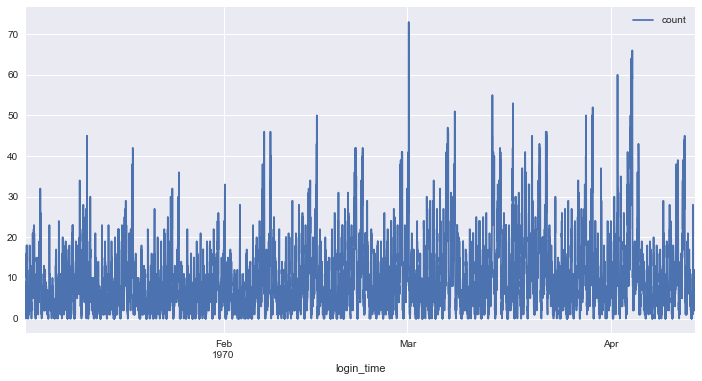

In [6]:
df_count = df_logins.resample('15min').sum()
df_count.plot(kind='line',figsize=(12,6))

there seem to be an increasing pattern over the period.

In [7]:
df_count.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


In [8]:
#create new columns for day and weekday 
df_count = df_count.assign(month_day=df_count.index.day)
df_count = df_count.assign(weekday=df_count.index.weekday)
df_count.head(20)

,count,month_day,weekday
login_time,,,
1970-01-01 20:00:00,2,1,3
1970-01-01 20:15:00,6,1,3
1970-01-01 20:30:00,9,1,3
1970-01-01 20:45:00,7,1,3
1970-01-01 21:00:00,1,1,3
1970-01-01 21:15:00,4,1,3
1970-01-01 21:30:00,0,1,3
1970-01-01 21:45:00,4,1,3
1970-01-01 22:00:00,9,1,3


In [9]:
outliner = np.quantile(df_count, 0.99)
df_clean = df_count[df_count['count'] >= outliner]
month_days = []
weekdays = []
for date in df_clean.index:
    month_days.append(date.day)
    weekdays.append(date.weekday())
    
df_clean_days = pd.DataFrame(month_days,columns=['day'],index=range(len(month_days)))
df_clean_weekdays = pd.DataFrame(weekdays,columns=['weekday'],index=range(len(weekdays)))

In [10]:
df_clean_days.day.value_counts()

21    25
4     24
22    18
15    18
28    17
7     15
8     15
14    14
29    14
3     13
12    13
13    11
1     11
18    10
11    10
6      9
19     9
27     8
5      8
17     7
10     4
20     4
2      4
25     2
24     1
16     1
30     1
Name: day, dtype: int64

In [11]:
df_clean_weekdays.weekday.value_counts()

5    104
6    103
4     48
3     15
2      7
1      7
0      2
Name: weekday, dtype: int64

The incrrease in user logins occur overwhelmingly on the weekends.

<AxesSubplot:xlabel='login_time'>

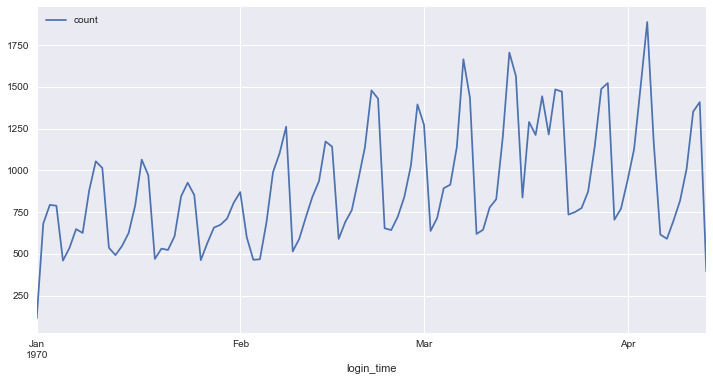

In [12]:
#resample to daily frequency
df_day = df_logins.resample('1D').sum()
df_day.plot(kind='line',figsize=(12,6))

The day plot confirmed that the login has increased over time.

### Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

With different activities in weekday, I would propose to track only the weekend.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
<br>a) how you will implement the experiment
<br>b) what statistical test(s) you will conduct to verify the significance of the observation
<br>c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.


Steps of experiment:
<br>
1. Take a random sample of more than 100 drivers
<br>
2. Calculate the percentage time that they spent in each city on the weekends
<br>
3. Implement the tll reimbursement policy for only a set period of time
<br>
4. After the period is overm sample the drivers again and calculate time spent on weekends
<br>
5. Using a Z-test for proportions under the below hypothesis:
    H0: There is no difference in the mean
    H1: there is a statistically significant difference

### Part 3 ‐ Predictive modeling

In [13]:
file = './ultimate_data_challenge.json'
df = pd.read_json(file)

In [14]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [15]:
#inspect dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [16]:
#break down trip counts by percentage
df_tripcounts = df['trips_in_first_30_days'].value_counts(normalize=True)*100
df_tripcounts.head(10)

0    30.780
1    28.216
2    14.804
3     7.576
4     5.124
5     3.232
6     2.268
7     1.638
8     1.178
9     0.942
Name: trips_in_first_30_days, dtype: float64

In [17]:
#What fraction of the observed users were retained?
np.sum(df_tripcounts[1:])

69.22

In [18]:
df = df.drop(df[df.phone.isna()==True].index,axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    41578 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [19]:
df['avg_rating_by_driver'].describe()

count    49406.000000
mean         4.777861
std          0.447114
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

In [20]:
df['avg_rating_of_driver'].describe()

count    41578.000000
mean         4.601467
std          0.617377
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [21]:
mean_rating_by_driver = df['avg_rating_by_driver'].mean()
mean_rating_of_driver = df['avg_rating_of_driver'].mean()

In [22]:
#fill missing values with mean value
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(value = mean_rating_by_driver)
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(value = mean_rating_of_driver)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [24]:
#convert to timestamp
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [25]:
#set current date 
current_date = df['last_trip_date'].max()

In [26]:
#find if user qualifies as active
df['active'] = df['last_trip_date'].apply(lambda date: 0 if (current_date-date).days>30 else 1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [27]:
df['active'].value_counts(normalize=True)*100

0    62.35989
1    37.64011
Name: active, dtype: float64

only 37.64% considered as active.

In [28]:
#create dummy variables for categorical features
df_features = pd.get_dummies(df,columns=['city','phone','ultimate_black_user'])
df_features.head()
#set target and drop unuseful columns
target = df_features['active']
df_features = df_features.drop(['last_trip_date','signup_date','active'],axis=1)

<AxesSubplot:xlabel='active', ylabel='avg_dist'>

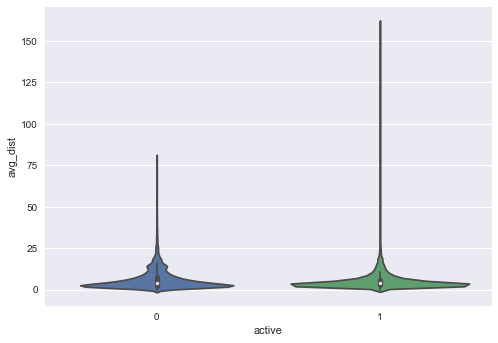

In [29]:
#visualize difference in average distance by activity of user
sns.violinplot(data = df, x = 'active', y = 'avg_dist')

In [30]:
pd.pivot_table(df,index='active',aggfunc={'avg_dist':['mean','std']})

avg_dist          
            mean       std
active                    
0       6.190725  6.184010
1       5.113930  4.617779

There is a difference in the average distance per trip taken between active users and inactive users, this will be important for predictive modeling.

(3.5, 5.2)

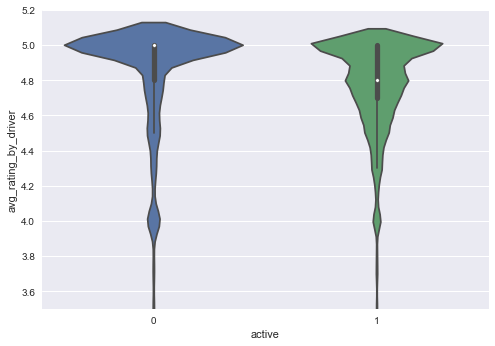

In [31]:
sns.violinplot(data = df, x = 'active', y = 'avg_rating_by_driver')
plt.ylim([3.5,5.2])

In [32]:
pd.pivot_table(df,index='active',aggfunc={'avg_rating_by_driver':['median','std']})

avg_rating_by_driver          
                     median       std
active                               
0                       5.0  0.503848
1                       4.8  0.328707

### Build Model

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [34]:
#scale data
scaler = QuantileTransformer()
scaled_features = scaler.fit_transform(df_features)

In [35]:
#split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2,random_state=42)

In [36]:
#build random forest model with 1000 estimators
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [37]:
rf.score(X_test,y_test)

0.7500251990726742

In [38]:
print(cross_val_score(rf, X_test, np.ravel(y_test), cv = 5))
print('Mean Cross Validated Score:', np.mean(cross_val_score(rf, X_test, np.ravel(y_test), cv = 5)))

[0.7511335  0.74647177 0.75201613 0.74697581 0.74395161]
Mean Cross Validated Score: 0.7480085520435524


In [39]:
df_importance = pd.DataFrame(zip(list(df_features.columns),rf.feature_importances_),index=range(df_features.columns.shape[0]),columns=['feature','importance'])
df_importance.sort_values(by='importance',ascending=False)

,feature,importance
5,avg_dist,0.299917
4,weekday_pct,0.134349
6,avg_rating_by_driver,0.113271
1,avg_rating_of_driver,0.082045
0,trips_in_first_30_days,0.080096
3,surge_pct,0.076841
2,avg_surge,0.067015
8,city_King's Landing,0.046087
10,phone_Android,0.019839
11,phone_iPhone,0.019577


City, phone type, and ultimate black user stats are all relatively unimportant for the model compared to average distance driven, weekday percentage, and the rating given to the passenger by the driver.

In [40]:
#more metrics for our model
precision_recall_fscore_support(y_test,y_pred)

(array([0.8       , 0.66675625]),
 array([0.8       , 0.66675625]),
 array([0.8       , 0.66675625]),
 array([6200, 3721]))

In [41]:
#weighted metrics
precision_recall_fscore_support(y_test,y_pred,average='weighted')

(0.7500251990726742, 0.7500251990726742, 0.7500251990726742, None)

In [42]:
#generate confusion matrix
confusion_matrix(y_test,y_pred)

array([[4960, 1240],
       [1240, 2481]])

In [ ]:
#initialize model
logit = LogisticRegression(solver='lbfgs')
#set parameter grid
param_grid = {'C':np.arange(0.5,5.1,0.1)}
#instantiate and fit grid search object
grid = GridSearchCV(logit,param_grid,cv=5)
grid.fit(X_train,np.ravel(y_train))

In [ ]:
grid.best_estimator_.C

In [ ]:
#find coefficients from Logistic Regression
logit_coef = LogisticRegression(C=grid.best_estimator_.C)
logit_coef.fit(X_train,y_train)
df_coef = pd.DataFrame(zip(list(df_features.columns),logit_coef.coef_[0]),index=range(df_features.columns.shape[0]),columns=['feature','coefficient'])
df_coef

In [ ]:
print(np.mean(cross_val_score(grid,X_test,np.ravel(y_test),cv=5)))

Logistic Regression perform almost identical to Random Forest model.

First, we have built a predictive model with 75% accuracy, that will be useful for future prediction.

Secondly, the insights from the model are arguably more important and lucrative for the company. Random Forest has given us the most important features and Logistic Regression shows us the effect of the features through the coefficients. Taking the three most important features, we can see the following effects on the "activity" of a rider after 6 months.

Average distance: This one is tricky because while our logistic regression model shows that an increase in average distance per trip in the first 30 days increases our chances of being an active user, interestingly, the mean avg_dist is larger for inactive riders than for active. Due to this ambiguity in the data, it may not be advisable to try to increase the distance of trips taken in the first 30 days.

weekday percentage: The chance of being an active user decrease as the percentage of week day use goes up. From this we can see that encouraging people to use the app on the weekend will be beneficial for the company revenue.

average rating by driver: For this feature, there is a decreased likelihood of being an active user as your rating goes up.

trips in the first 30 days: As the number of trips in the first 30 days increases, so does the chance that a rider is active after 6 months.

Based on these insights gained from the model, there are several recomendations for the company.

Offer incentives to riders to use the app on the weekends
Incentivize riders to take more trips during their first 30 days on the app

Following these guidelines will increase the chances of more active users in the long term, and therefore more revenue for the company.